In [2]:
import pandas as pd
from pandas.io.json import build_table_schema
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import numpy as np
import scipy as sp
import os
import datetime
#import xgboost as xgb
# import visualization as vis
from pandas.plotting import scatter_matrix
import warnings
%matplotlib inline

/Users/rachelkogan/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
#macro = pd.read_csv('macro_small.csv', header='infer', parse_dates=['timestamp'])
macro = pd.read_csv('macro_small.csv', header='infer')

In [4]:
#clean up dates for macro

macro['year'] = macro['timestamp'].map(lambda x: int(x.split('-')[0]))
macro['month'] = macro['timestamp'].map(lambda x: int(x.split('-')[1]))
macro['day'] = macro['timestamp'].map(lambda x: int(x.split('-')[2]))

macro['date'] = macro.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [5]:
macro.corr(method='pearson', min_periods=1)

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,rent_price_4.room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,year,month,day
oil_urals,1.000000,-0.721188,0.826810,-0.935144,-0.890700,-0.842526,0.783870,0.066300,-0.984898,-0.967964,...,-0.510139,-0.586065,-0.535291,0.039896,-0.349284,-0.056474,0.079831,-0.858253,0.000492,0.007549
gdp_quart,-0.721188,1.000000,-0.711272,0.788908,0.775045,0.848557,-0.476176,-0.028098,0.764328,0.769388,...,0.363324,0.608423,0.769495,0.439451,0.674623,0.186274,0.253098,0.848106,0.017664,-0.003477
gdp_quart_growth,0.826810,-0.711272,1.000000,-0.888068,-0.881122,-0.845434,0.600667,0.107339,-0.829126,-0.821164,...,-0.444215,-0.700525,-0.634269,-0.105841,-0.534160,-0.096708,0.042339,-0.860701,-0.044860,0.001131
cpi,-0.935144,0.788908,-0.888068,1.000000,0.978560,0.952849,-0.752882,-0.097589,0.940759,0.930779,...,0.534011,0.655168,0.604043,0.112616,0.460364,0.091767,-0.004113,0.965138,0.019761,-0.009033
ppi,-0.890700,0.775045,-0.881122,0.978560,1.000000,0.934288,-0.704971,-0.130572,0.894056,0.877581,...,0.534013,0.668977,0.625610,0.150126,0.496368,0.113000,0.032382,0.941357,0.107689,-0.007750
gdp_deflator,-0.842526,0.848557,-0.845434,0.952849,0.934288,1.000000,-0.630995,-0.012014,0.862984,0.855238,...,0.485417,0.636431,0.668345,0.241001,0.544268,0.125498,0.050169,0.993258,-0.116788,-0.008711
balance_trade,0.783870,-0.476176,0.600667,-0.752882,-0.704971,-0.630995,1.000000,0.453725,-0.768679,-0.754320,...,-0.320999,-0.263131,-0.249986,0.148260,-0.054541,0.003185,0.158717,-0.632904,-0.208656,0.010601
balance_trade_growth,0.066300,-0.028098,0.107339,-0.097589,-0.130572,-0.012014,0.453725,1.000000,-0.047314,-0.045492,...,0.146774,0.166427,0.133380,0.023853,0.237264,0.130346,0.018464,0.000967,-0.486966,-0.001392
usdrub,-0.984898,0.764328,-0.829126,0.940759,0.894056,0.862984,-0.768679,-0.047314,1.000000,0.991249,...,0.491199,0.581084,0.563609,0.012372,0.378332,0.061403,-0.034882,0.877691,-0.022507,-0.003737
eurrub,-0.967964,0.769388,-0.821164,0.930779,0.877581,0.855238,-0.754320,-0.045492,0.991249,1.000000,...,0.499440,0.569397,0.587503,0.063263,0.395711,0.075306,-0.011268,0.877905,-0.021420,-0.005767


In [6]:
#read in test & training sets
train = pd.read_csv('train_cleaned.csv', header='infer')
test = pd.read_csv('test_cleaned.csv', header='infer')

In [7]:
#clean up dates in training data
train['year'] = train['timestamp'].map(lambda x: int(x.split('-')[0]))
train['month'] = train['timestamp'].map(lambda x: int(x.split('-')[1]))
train['day'] = train['timestamp'].map(lambda x: int(x.split('-')[2]))

train['date'] = train.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [63]:
#clean up dates in test data
test['year'] = test['timestamp'].map(lambda x: int(x.split('-')[0]))
test['month'] = test['timestamp'].map(lambda x: int(x.split('-')[1]))
test['day'] = test['timestamp'].map(lambda x: int(x.split('-')[2]))

test['date'] = test.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)

In [66]:
train_price = train[['price_doc', 'year', 'month', 'date']]


In [64]:
train_price_by_month = train_price.groupby(['year', 'month']).agg('mean')
train_price_by_month.head()

price_doc
year month              
2011 8      5.850000e+06
     9      6.007330e+06
     10     5.808422e+06
     11     6.115835e+06
     12     5.824306e+06

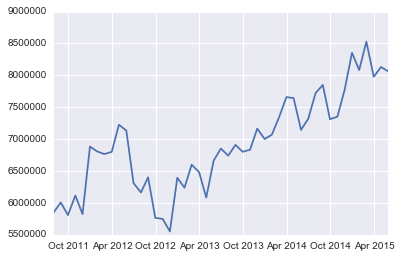

In [10]:
x = [datetime.date(2011, 8, 1) + datetime.timedelta(x*365/12) for x in range(47)]

plt.plot(x, train_price_by_month['price_doc'])
plt.show()

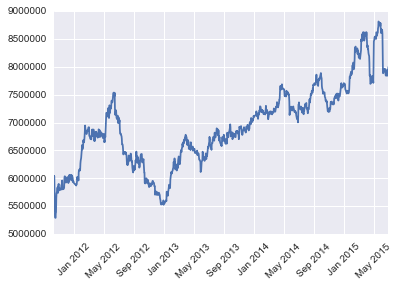

In [13]:
train_price_by_date = train_price.groupby(['date']).agg('mean')[['price_doc']]
train_price_by_date
train_price_by_date_rolling = train_price_by_date.rolling(window=30).mean()

plt.plot(train_price_by_date_rolling.index, train_price_by_date_rolling['price_doc'])
plt.xticks(rotation=45)
ax = plt.gca()
plt.show()

In [20]:
train_price_by_date_rolling.reset_index(inplace=True)
train_price_by_date_rolling

,date,price_doc
0,2011-08-20,NaN
1,2011-08-23,NaN
2,2011-08-27,NaN
3,2011-09-01,NaN
4,2011-09-05,NaN
5,2011-09-06,NaN
6,2011-09-08,NaN
7,2011-09-09,NaN
8,2011-09-10,NaN
9,2011-09-13,NaN


In [72]:
#merge macro data set with 30 day rolling price data
macro_merged = macro.merge(train_price_by_date_rolling, how='inner', on='date')

macro_merged = macro_merged.iloc[29:,:]
macro_merged.drop(['year', 'month', 'day', 'timestamp'], axis=1, inplace=True)
macro_merged.head()

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,fixed_basket,rent_price_4.room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,date,price_doc
29,108.24,15663.6,5.0,353.0,436.5,86.721,17.199,18.1,31.5611,43.1144,...,12922.97,151.68,81.5,63.84,52.25,43.46,38.1,31.11,2011-10-10,5.995692e+06
30,108.24,15663.6,5.0,353.0,436.5,86.721,17.199,18.1,31.5450,43.0199,...,12922.97,151.68,81.5,63.84,52.25,43.46,38.1,31.11,2011-10-11,6.046652e+06
31,108.24,15663.6,5.0,353.0,436.5,86.721,17.199,18.1,31.1048,42.9585,...,12922.97,151.68,81.5,63.84,52.25,43.46,38.1,31.11,2011-10-12,6.027557e+06
32,108.24,15663.6,5.0,353.0,436.5,86.721,17.199,18.1,31.2110,42.8987,...,12922.97,151.68,81.5,63.84,52.25,43.46,38.1,31.11,2011-10-13,6.037129e+06
33,108.24,15663.6,5.0,353.0,436.5,86.721,17.199,18.1,30.8775,42.7476,...,12922.97,151.68,81.5,63.84,52.25,43.46,38.1,31.11,2011-10-14,5.791154e+06


In [82]:
#separate out the macro data that is just for test dates
min_test_date = test['date'].min()
max_test_date = test['date'].max()
print min_test_date, max_test_date

macro_test = macro[(macro['date'] >= min_test_date) & (macro['date'] <= max_test_date)]

2015-07-01 2016-05-30


In [83]:
#save as CSVs
macro_test.to_csv('macro_test.csv')
macro_merged.to_csv('macro_merged.csv')

In [95]:
#I did the modelling and predictions in R -- reading them back in!

macro_test_pred = pd.read_csv('macro_test_pred.csv')

macro_test_pred.drop('Unnamed: 0', axis=1, inplace=True)
macro_test_pred.head()

macro_test_pred_only = macro_test_pred[['date', 'macro_test.pred']]
macro_test_pred_only.head()

,date,macro_test.pred
0,2015-07-01,8.276122e+06
1,2015-07-02,8.272234e+06
2,2015-07-03,8.353321e+06
3,2015-07-04,8.400769e+06
4,2015-07-05,8.395338e+06


In [99]:
#clean up dates for macro_test_pred_only

macro_test_pred_only['year'] = macro_test_pred_only['date'].map(lambda x: int(x.split('-')[0]))
macro_test_pred_only['month'] = macro_test_pred_only['date'].map(lambda x: int(x.split('-')[1]))
macro_test_pred_only['day'] = macro_test_pred_only['date'].map(lambda x: int(x.split('-')[2]))

macro_test_pred_only['date'] = macro_test_pred_only.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)


AttributeError: 'datetime.date' object has no attribute 'split'

In [101]:
macro_test_pred_only.drop(['year', 'month', 'day'], inplace=True, axis=1)
macro_test_pred_only.head()

/Users/rachelkogan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,macro_test.pred
0,2015-07-01,8.276122e+06
1,2015-07-02,8.272234e+06
2,2015-07-03,8.353321e+06
3,2015-07-04,8.400769e+06
4,2015-07-05,8.395338e+06


In [104]:
#merge macro price level predictions with test data by date
test_pred = test.merge(macro_test_pred_only, how='left', on='date')
test_pred.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,workplaces_km,young_all,young_female,young_male,zd_vokzaly_avto_km,year,month,day,date,macro_test.pred
0,30474,2015-07-01,39.0,20.7,2,9.0,1.0,1998.0,1.0,8.9,...,7.922610,30808,14557,16251,27.553486,2015,7,1,2015-07-01,8.276122e+06
1,30475,2015-07-01,79.2,NaN,8,17.0,1.0,NaN,3.0,1.0,...,9.672779,574,277,297,27.421853,2015,7,1,2015-07-01,8.276122e+06
2,30476,2015-07-01,40.5,25.1,3,5.0,2.0,1960.0,2.0,4.8,...,3.506298,13799,6862,6937,10.093318,2015,7,1,2015-07-01,8.276122e+06
3,30477,2015-07-01,62.8,36.0,17,17.0,1.0,2016.0,2.0,62.8,...,11.306566,1021,493,529,37.436772,2015,7,1,2015-07-01,8.276122e+06
4,30478,2015-07-01,40.0,40.0,17,17.0,1.0,NaN,1.0,1.0,...,9.479093,574,277,297,25.699461,2015,7,1,2015-07-01,8.276122e+06


In [114]:
#check that none of the predictions are null
print test_pred['macro_test.pred'].isnull().values.any()
print test_pred['macro_test.pred'].isnull().sum()

False
0


In [119]:
#save just the predictions into a csv
test_pred = test_pred[['id', 'macro_test.pred']]
test_pred = test_pred.rename(columns = {'macro_test.pred':'price_doc'})

test_pred.to_csv('test_pred_macro.csv', index=False)
print test_pred.shape

(7662, 2)


Everything below is a work in progress.

In [57]:
#Import Library
from sklearn.ensemble import RandomForestRegressor
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create Random Forest object
model= RandomForestRegressor()
X_train = macro_merged.drop(['price_doc'], axis=1)
y_train = macro_merged['price_doc']


dir(model)
# Train the model using the training sets and check score
model.fit(X_train, y_train.reshape([-1, 1]))
#Predict Output
#predicted = model.predict(x_test)

/Users/rachelkogan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


TypeError: float() argument must be a string or a number

In [46]:
print X_train.shape
print y_train.shape
y_train.reshape([-1, 1]).shape

(1132, 34)
(1132,)


/Users/rachelkogan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


(1132, 1)

In [58]:
print type(X_train)
print type(y_train.reshape([-1, 1]))

<class 'pandas.core.frame.DataFrame'>
<type 'numpy.ndarray'>


/Users/rachelkogan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [60]:
macro_merged.tail()

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,fixed_basket,rent_price_4.room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,date,price_doc
1156,61.4105,18209.7,-2.8,489.5,568.9,123.661,16.416,32.9,54.6719,61.2602,...,18720.65,167.37,138.14,72.24,50.93,49.01,38.91,30.29,2015-06-25,7.837148e+06
1157,61.4105,18209.7,-2.8,489.5,568.9,123.661,16.416,32.9,54.8064,61.2079,...,18720.65,167.37,138.14,72.24,50.93,49.01,38.91,30.29,2015-06-26,7.862176e+06
1158,61.4105,18209.7,-2.8,489.5,568.9,123.661,16.416,32.9,54.8064,61.2079,...,18720.65,167.37,138.14,72.24,50.93,49.01,38.91,30.29,2015-06-27,7.943047e+06
1159,61.4105,18209.7,-2.8,489.5,568.9,123.661,16.416,32.9,55.5277,62.2591,...,18720.65,167.37,138.14,72.24,50.93,49.01,38.91,30.29,2015-06-29,7.938881e+06
1160,61.4105,18209.7,-2.8,489.5,568.9,123.661,16.416,32.9,55.2655,61.6334,...,18720.65,167.37,138.14,72.24,50.93,49.01,38.91,30.29,2015-06-30,7.994729e+06


In [62]:
test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,water_km,water_treatment_km,work_all,work_female,work_male,workplaces_km,young_all,young_female,young_male,zd_vokzaly_avto_km
0,30474,2015-07-01,39.0,20.7,2,9.0,1.0,1998.0,1.0,8.9,...,0.248151,0.967696,121369,62231,59138,7.922610,30808,14557,16251,27.553486
1,30475,2015-07-01,79.2,NaN,8,17.0,1.0,NaN,3.0,1.0,...,0.799853,16.049420,2566,1211,1356,9.672779,574,277,297,27.421853
2,30476,2015-07-01,40.5,25.1,3,5.0,2.0,1960.0,2.0,4.8,...,1.384824,11.749900,91795,47061,44734,3.506298,13799,6862,6937,10.093318
3,30477,2015-07-01,62.8,36.0,17,17.0,1.0,2016.0,2.0,62.8,...,0.233017,5.061917,4568,2155,2414,11.306566,1021,493,529,37.436772
4,30478,2015-07-01,40.0,40.0,17,17.0,1.0,NaN,1.0,1.0,...,0.394422,16.784630,2566,1211,1356,9.479093,574,277,297,25.699461
